# Which Teams are Failing to Meet Expectations?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import datetime
from scipy.constants import golden

from PIL import Image
import urllib
import json
import os

In [3]:
font_path = "../Grafici/assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../Grafici/assets/stylesheets/soc_base.mplstyle")

## The data

Here we read 538's predictions and compute the expected point tally of each side, using the pre-match probabilities assigned by 538.

In [4]:
df = pd.read_csv("../FiveThirtyEight/soccer-spi/16-05/spi_matches.csv", sep=",", decimal=".")
df = df[(df.league=='Italy Serie A') & (df.season >= 2022) ]
#df = df[pd.to_datetime(df.date) <= datetime.datetime.today()]

Custom function to compute points across teams.

In [5]:
def compute_points(x,y):
    '''
    This function computed the points achieved by each side.
    '''
    if x > y:
        return 3
    if x == y:
        return 1
    else:
        return 0

In [6]:
df['xpoints1'] = df['prob1']*3 + df['probtie']
df['xpoints2'] = df['prob2']*3 + df['probtie']
df['points1'] = [compute_points(x,y) for x,y in zip(df['score1'], df['score2'])]
df['points2'] = [compute_points(y,x) for x,y in zip(df['score1'], df['score2'])]
df

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,xpoints1,xpoints2,points1,points2
56895,2022,2022-08-13,1854,Italy Serie A,AC Milan,Udinese,78.31,57.94,0.6751,0.1206,...,2.53,0.48,0.99,1.30,4.20,2.10,2.2296,0.5661,3,0
56897,2022,2022-08-13,1854,Italy Serie A,Sampdoria,Atalanta,52.95,73.01,0.2101,0.5546,...,0.56,2.01,1.40,1.21,0.00,1.58,0.8656,1.8991,0,3
56920,2022,2022-08-13,1854,Italy Serie A,Lecce,Internazionale,50.41,82.17,0.1144,0.6995,...,0.64,2.43,0.70,2.38,1.05,2.10,0.5292,2.2845,0,3
56924,2022,2022-08-13,1854,Italy Serie A,Monza,Torino,52.84,62.83,0.3254,0.3833,...,1.15,2.29,0.84,0.79,1.05,2.10,1.2675,1.4412,0,3
57017,2022,2022-08-14,1854,Italy Serie A,Lazio,Bologna,69.72,56.11,0.5987,0.1771,...,0.83,1.59,0.98,0.58,2.10,0.84,2.0203,0.7555,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67366,2022,2023-06-03,1854,Italy Serie A,Sassuolo,Fiorentina,65.30,72.12,0.3524,0.3892,...,NaN,NaN,NaN,NaN,NaN,NaN,1.3156,1.4260,0,0
67367,2022,2023-06-03,1854,Italy Serie A,Atalanta,Monza,69.62,60.21,0.5270,0.2272,...,NaN,NaN,NaN,NaN,NaN,NaN,1.8268,0.9274,0,0
67368,2022,2023-06-03,1854,Italy Serie A,Torino,Internazionale,67.97,79.44,0.2848,0.4476,...,NaN,NaN,NaN,NaN,NaN,NaN,1.1220,1.6104,0,0
67369,2022,2023-06-03,1854,Italy Serie A,Cremonese,Salernitana,48.36,48.33,0.4204,0.3094,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5315,1.1985,0,0


In [7]:
df_team1 = df[['team1', 'xpoints1', 'points1']]
df_team2 = df[['team2', 'xpoints2', 'points2']]
df_team1.columns = ['team', 'xpoints', 'points']
df_team2.columns = ['team', 'xpoints', 'points']
df_g = (
    pd.concat([df_team1, df_team2])
    .groupby(['team']).sum()
    .reset_index()
    .assign(difference = lambda x: x.points - x.xpoints)
)
df_g

,team,xpoints,points,difference
0,AC Milan,71.6953,61,-10.6953
1,AS Roma,68.0913,59,-9.0913
2,Atalanta,64.2693,58,-6.2693
3,Bologna,44.4079,47,2.5921
4,Cremonese,36.4528,24,-12.4528
5,Empoli,38.0155,39,0.9845
6,Fiorentina,58.9415,49,-9.9415
7,Internazionale,75.7928,66,-9.7928
8,Juventus,63.6363,69,5.3637
9,Lazio,60.4200,65,4.5800


For the logos, we need to do some manual labour and get the team's Fotmob ID.

In [8]:

team_map = {
    'team': [
        "Napoli",
        "Lazio",
        "Juventus",
        "Internazionale",
        "Atalanta",
        "AC Milan",
        "AS Roma",
        "Fiorentina",
        "Bologna",
        "Monza",
        "Torino",
        "Sassuolo",
        "Udinese",
        "Salernitana",
        "Empoli",
        "Lecce",
        "Verona",
        "Spezia",
        "Cremonese",
        "Sampdoria"
    ],
    'fotmob_id':[
        9875,
        8543,
        9885,
        8636,
        8524,
        8564,
        8686,
        8535,
        9857,
        6504,
        9804,
        7943,
        8600,
        6480,
        8534,
        9888,
        9876,
        9881,
        7801,
        9882
    ],
}

team_map = pd.DataFrame(team_map)
team_map

,team,fotmob_id
0,Napoli,9875
1,Lazio,8543
2,Juventus,9885
3,Internazionale,8636
4,Atalanta,8524
5,AC Milan,8564
6,AS Roma,8686
7,Fiorentina,8535
8,Bologna,9857
9,Monza,6504


In [9]:
df_g = pd.merge(df_g, team_map)
df_g = df_g.sort_values(by="points", ascending=False)
df_g

,team,xpoints,points,difference,fotmob_id
12,Napoli,76.4042,83,6.5958,9875
8,Juventus,63.6363,69,5.3637,9885
7,Internazionale,75.7928,66,-9.7928,8636
9,Lazio,60.4200,65,4.5800,8543
0,AC Milan,71.6953,61,-10.6953,8564
1,AS Roma,68.0913,59,-9.0913,8686
2,Atalanta,64.2693,58,-6.2693,8524
6,Fiorentina,58.9415,49,-9.9415,8535
11,Monza,42.8183,49,6.1817,6504
17,Torino,50.3349,49,-1.3349,9804


Finally, we create a function that takes the timeline of this xPoints and actual points so we can plot a time series.

In [10]:
def get_cumpoints_df(team, data = df):

    df = data.copy()
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    is_in_home = df[(df['team1'] == team)][['team1', 'points1', 'xpoints1', 'date']].reset_index(drop=True)
    is_in_away = df[(df['team2'] == team)][['team2', 'points2', 'xpoints2', 'date']].reset_index(drop=True)
    is_in_home.columns = ['team', 'points', 'xpoints', 'date']
    is_in_away.columns = ['team', 'points', 'xpoints', 'date']
    df = pd.concat([is_in_home, is_in_away]).sort_values(by='date', ascending=True).reset_index(drop=True)
    df['cum_points'] = df['points'].cumsum()
    df['cum_xpoints'] = df['xpoints'].cumsum()
    return df

# Check to see if it works
get_cumpoints_df('Napoli')

,team,points,xpoints,date,cum_points,cum_xpoints
0,Napoli,3,1.7358,2022-08-15,3,1.7358
1,Napoli,3,2.3339,2022-08-21,6,4.0697
2,Napoli,1,1.5974,2022-08-28,7,5.6671
3,Napoli,1,2.4032,2022-08-31,8,8.0703
4,Napoli,3,1.4886,2022-09-03,11,9.5589
5,Napoli,3,2.5022,2022-09-10,14,12.0611
6,Napoli,3,1.2881,2022-09-18,17,13.3492
7,Napoli,3,2.1956,2022-10-01,20,15.5448
8,Napoli,3,2.3103,2022-10-09,23,17.8551
9,Napoli,3,2.5265,2022-10-16,26,20.3816


## The Visual

In [11]:
xpts_color = '#1F1B8E'
pts_color = '#D49208'
upp_diff = '#1A85FF'
low_diff = '#9C0404'

In [12]:
def diff_color(difference):
    if difference > 2.5:
        return upp_diff
    elif difference < -0.5:
        return low_diff
    return '#000000'

In [16]:
selector = [x % 2 == 0 for x in range(0, 38)]
def plot_point_difference(ax, team, label_y = False, data=df):
    ax.grid(ls='--', color='lightgrey')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linestyle('dashed')
    ax.tick_params(color='lightgrey', labelsize=8, labelcolor='grey')
    test_df = get_cumpoints_df(team, data)[selector]

    ax.plot(test_df.index + 1, test_df['cum_points'], marker='o', mfc='white', ms=4, color=pts_color)
    ax.plot(test_df.index + 1, test_df['cum_xpoints'], marker='o', mfc='white', ms=4, color=xpts_color)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.set_ylim(-1,90)
    ax.set_xlim(0, 39) # aggiungere una colonna in più
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    #ax.set_xticklabels([])
    mid_point = test_df['cum_points'].iloc[-1] + (test_df['cum_xpoints'].iloc[-1] - test_df['cum_points'].iloc[-1])/2
    difference = test_df['cum_points'].iloc[-1] - test_df['cum_xpoints'].iloc[-1]
    
    '''
    clr = '#000000'
    if difference > 2.5:
        clr = upp_diff
    elif difference < -0.5:
        clr = low_diff
        
    text_ = ax.annotate(
        xy=(ax.get_xlim()[1], mid_point),
        text=f'{difference:.1f}',
        xytext=(-5,0),
        ha='center',
        va='center',
        color=clr,
        weight='bold',
        size=12,
        textcoords='offset points'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
    )'''
    
    if label_y:
        ax.set_ylabel('Points', color='grey', size=8)
    else:
        ax.set_yticklabels([])
    return

In [22]:
def multiplot(nrows, ncols, data = df_g, off=1):
    fig = plt.figure(figsize=(16, 9), dpi = 200)
    gspec = gridspec.GridSpec(
        ncols=ncols, nrows=nrows, figure=fig, 
        height_ratios = [(1/nrows)*2.6 if x % 2 != 0 else (1/nrows)/2.6 for x in range(nrows)], 
        hspace=0.4,
    )



    plot_counter = 0
    logo_counter = 0
    for row in range(nrows):
        for col in range(ncols):
            if row % 2 != 0:
                ax = plt.subplot(
                    gspec[row, col],
                    facecolor = "#EFE9E6"
                )
                team = data['team'].iloc[plot_counter]
                if col == 0:
                    label_y = True
                else:
                    label_y = False

                plot_point_difference(ax, team, label_y)           
                plot_counter += 1
            else:
                teamId = data['fotmob_id'].iloc[logo_counter]
                teamName = data['team'].iloc[logo_counter]
                xpoints = data['xpoints'].iloc[logo_counter]
                apoints = data['points'].iloc[logo_counter]
                fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
                logo_ax = plt.subplot(
                    gspec[row,col],
                    anchor = 'NW', facecolor = '#EFE9E6'
                )
                club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{teamId:.0f}.png')).convert('LA')
                logo_ax.imshow(club_icon)
                logo_ax.axis('off')
                # -- Add the team name
                diff = data.difference.iloc[logo_counter]
                ax_text(
                    x = 1.2, 
                    y = 0.9,
                    s = f'<{teamName} (#{logo_counter+off})>\n<Xpunti: {xpoints:.1f}> <|> <Punti Effettivi: {apoints:.0f}> <|> <Differenza:> <{diff:.1f}>',
                    ax = logo_ax, 
                    highlight_textprops=[{'weight':'bold', 'font':'DM Sans'},{'size':'7', 'color': xpts_color}, {'size':'7', 'color': 'grey'}, {'size':'7', 'color': pts_color}, {'size':'7', 'color': 'grey'}, {'size':'7', 'color': 'grey'}, {'size':'7', 'color': diff_color(diff)},],
                    font = 'Karla', 
                    ha = 'left', 
                    size = 12,
                    vsep=2,
                    annotationbbox_kw = {'xycoords':'axes fraction'}
                )
                logo_counter += 1

    return

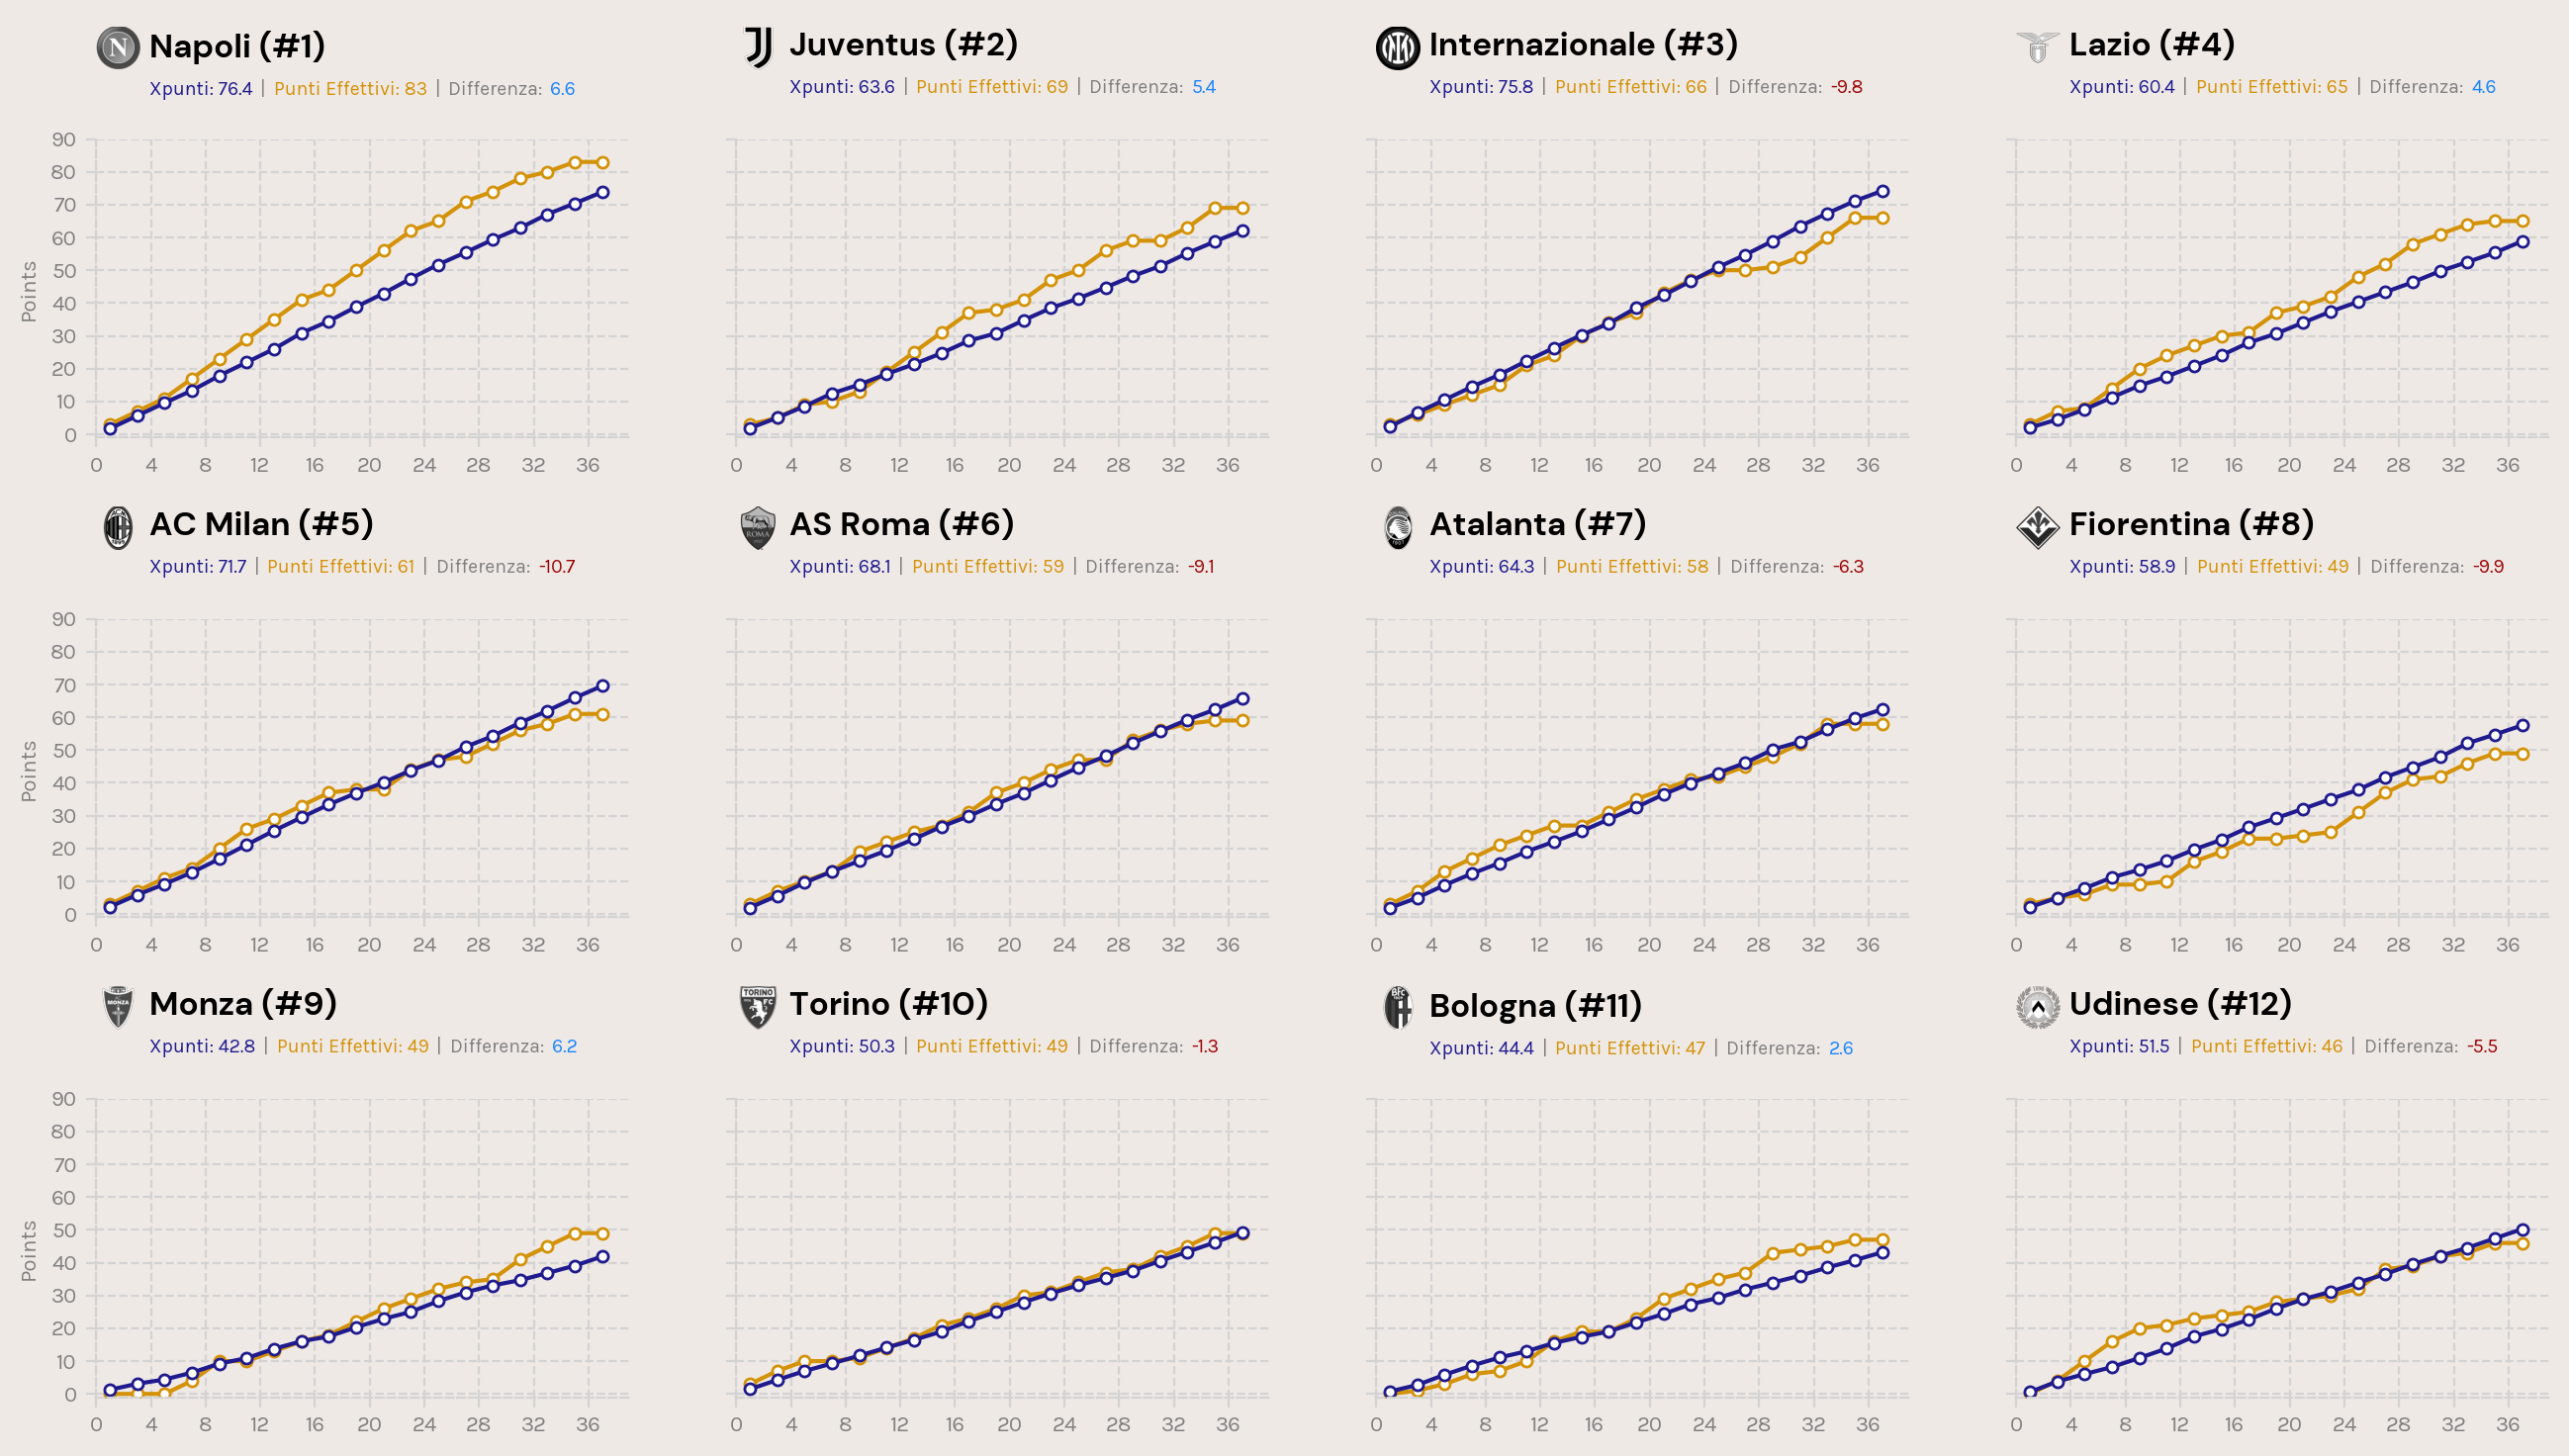

In [23]:
multiplot(6, 4, df_g[:13])
plt.savefig(
    "../Grafici/figures/PTS-xPTS_12.png",
    dpi = 600,
    facecolor = "#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent = False
)

plt.savefig(
    "../Grafici/figures/PTS-xPTS_12_tr.png",
    dpi = 600,
    facecolor = "none",
    bbox_inches="tight",
    edgecolor="none",
    transparent = True
)

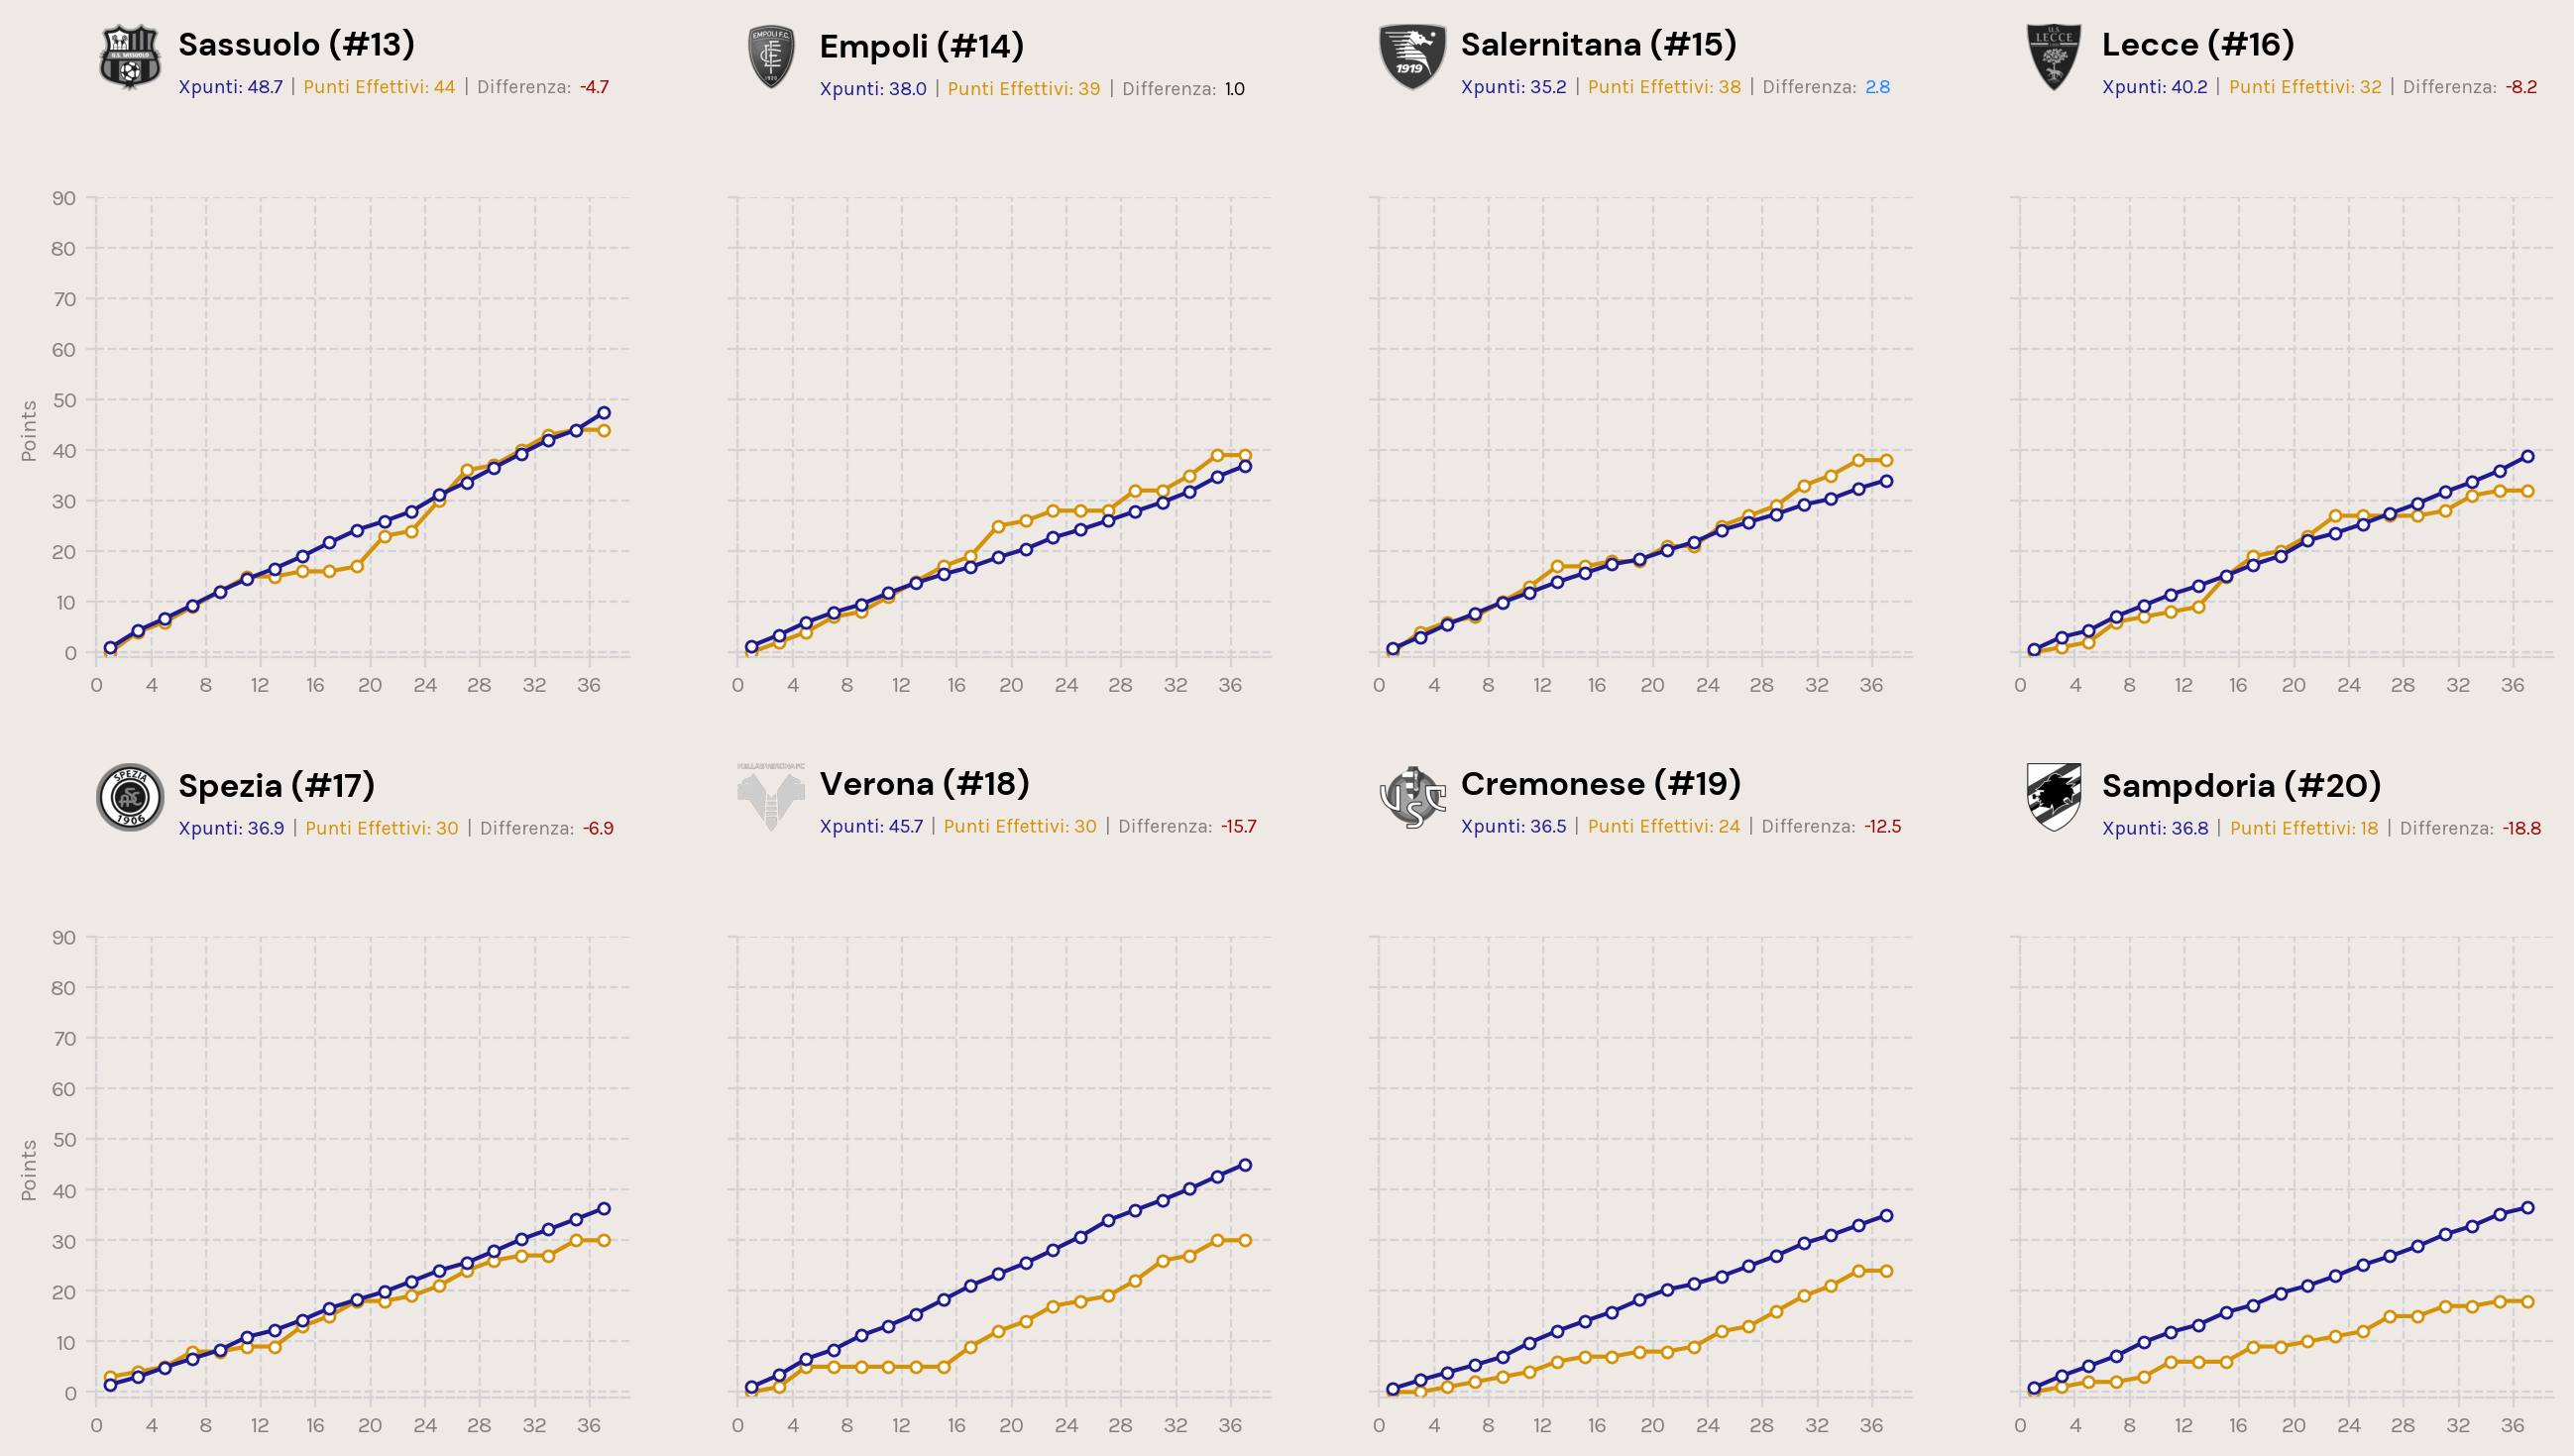

In [24]:
multiplot(4, 4, df_g[12:], off=13)
plt.savefig(
    "../Grafici/figures/PTS-xPTS_8.png",
    dpi = 600,
    facecolor = "#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent = False
)

plt.savefig(
    "../Grafici/figures/PTS-xPTS_8_tr.png",
    dpi = 600,
    facecolor = "none",
    bbox_inches="tight",
    edgecolor="none",
    transparent = True
)